In [21]:
import random

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

random.seed(42)

In [22]:
digits = load_digits()

In [23]:
X = digits.data / 16.0
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [24]:
clf = MLPClassifier(hidden_layer_sizes=(), activation="relu", random_state=1, max_iter=100)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(), max_iter=100, random_state=1)

In [25]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9161098737936154, 0.9288888888888889)

In [26]:
def dump_mlp(clf, feature_vars, indent_char="", endl="\n", precision=8):
    format_str = "{:." + str(precision) + "f}"
    code = ""
    len_layers = len(clf.coefs_)
    for c, n in enumerate(feature_vars):
        code += f"{indent_char}h_0_{c} = {n};{endl}"

    for layer_id in range(len_layers):
        code += endl
        for j in range(clf.coefs_[layer_id].shape[1]):
            code += f"{indent_char}h_{layer_id + 1}_{j} = {format_str.format(clf.intercepts_[layer_id][j])}"
            for c in range(len(clf.coefs_[layer_id][:, j])):
                code += f" + ({format_str.format(clf.coefs_[layer_id][c, j])} * h_{layer_id}_{c})"
            code += f";{endl}"
            if layer_id < len_layers - 1:
                if clf.activation == "relu":
                    code += f"{indent_char}if(h_{layer_id + 1}_{j} < 0){endl}"
                    code += f"{indent_char} h_{layer_id + 1}_{j} = 0;{endl}"
            else:
                code += f"{indent_char}y_{j} = h_{layer_id + 1}_{j};{endl}"
    return code

In [70]:
num_symbolic_vars = 10
symbolic_vars_id = random.sample(list(range(X_train.shape[1])), num_symbolic_vars)

In [71]:
idx = 4
x_origin = X[idx]
y_origin = y[idx]
print(y_origin, clf.predict(x_origin.reshape(1, -1)))

feature_names = [f"var_{j}" if j in symbolic_vars_id else str(x_origin[j]) for j in range(x_origin.shape[0])]

4 [4]


In [72]:
mlp_code = dump_mlp(clf, feature_names)

adv_condition = "(" + " || ".join([f"(y_{c} > y_{y_origin})" for c in range(len(clf.classes_)) if y_origin != c]) + ")"
perturbation_condition = "(" + " && ".join([f"(var_{i} >= 0) && (var_{i} <= 1.0)" for i in symbolic_vars_id]) + ")"

#mlp_code+=f"\nif ({adv_condition})\n return 1;\nreturn 0;"
mlp_code+=f"\nif ({adv_condition} && {perturbation_condition})\n return 1;\nreturn 0;"

In [73]:
with open("example/nn.gym", mode="w") as f:
    f.write(mlp_code)

In [69]:
symbolic_vars_id

[14, 3, 35, 31, 28]

In [56]:
clf.predict(x_origin.reshape(1, -1))

array([4])

In [57]:
x_adv = x_origin.reshape(1, -1).copy()

In [58]:
x_adv[:, 57] = 1.711993
x_adv[:, 47] = -0.796565
x_adv[:, 43] = 1.930713
x_adv[:, 37] = 1.776542
x_adv[:, 34] = 1.354539

In [59]:
clf.predict(x_adv), clf.predict(x_origin.reshape(1, -1))

(array([7]), array([4]))

In [60]:
clf.predict_proba(x_adv), clf.predict_proba(x_origin.reshape(1, -1))

(array([[0.01668097, 0.14923183, 0.00976213, 0.03304357, 0.24750146,
         0.02749374, 0.06214523, 0.24839706, 0.13623026, 0.06951374]]),
 array([[0.03848151, 0.07646758, 0.00566983, 0.00734964, 0.73606777,
         0.01131648, 0.08001591, 0.0092108 , 0.02642967, 0.0089908 ]]))

In [61]:
from matplotlib import pyplot as plt

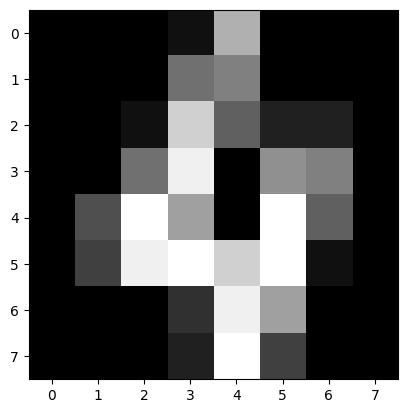

In [66]:
plt.imshow(x_origin.reshape(8, 8), cmap="gray")